In [1]:
import torch
from torch import nn

class EncoderDecoder(nn.Module):
    '''A standard Encoder-Decoder architecture'''
    def __init__(self, encoder, decoder, src_embed, tar_embed, generator):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tar_embed = tar_embed
        self.generator = generator
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask) 
    
    def decode(self, memory, src_mask, tar, tar_mask):
        return self.decoder(self.tar_embed(tar), memory, src_mask, tar_mask)
    
    def forward(self, src, tar, src_mask, tar_mask):
        return self.decode(self.encode(src, src_mask), src_mask, tar, tar_mask)

## Generator

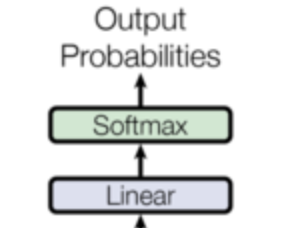

In [2]:
from torch import nn
from torch.nn.functional import log_softmax

class Generator(nn.Module):
    '''Standard linear + softmax generation step'''
    def __init__(self, d_model, vocab):
        super().__init__()
        self.proj = nn.Linear(d_model, vocab)
    
    def forward(self, x):
        return log_softmax(self.proj(x), dim=-1)

## x N

In [3]:
import copy

def clones(module, N):
    '''Stack identical layers (N=6)'''
    modules = [copy.deepcopy(module) for _ in range(N)]
    
    return nn.ModuleList(modules)

## Add & Norm

That is, the output of each sub-layer is $\mathrm{LayerNorm}(x +
\mathrm{Sublayer}(x))$, where $\mathrm{Sublayer}(x)$ is the function
implemented by the sub-layer itself.  We apply dropout
[(cite)](http://jmlr.org/papers/v15/srivastava14a.html) to the
output of each sub-layer, before it is added to the sub-layer input
and normalized.

In [4]:
class LayerNorm(nn.Module):
    '''Normalize weights (into smaller range)
    Formula : (x-mean) / (std+eps)
    '''
    def __init__(self, size, eps=1e-6):
        super().__init__()
        self.a_2 = nn.Parameter(torch.ones(size)) #scaling param
        self.b_2 = nn.Parameter(torch.zeros(size)) #bias param
    
    def forward(self, x):
        # compute mean, std along the last dimension
        mean = x.mean(-1, keepdim=True) 
        std = x.std(-1, keepdim=True)
        
        return self.a_2 * (x-mean) / (std+self.eps) + self.b_2

In [5]:
class ResConnection(nn.Module):
    '''apply residual connection to 
    1) preserve original information
    2) prevent gradient vanishing
    '''
    def __init__(self, size, dropout):
        super().__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer):
        return self.norm(x + self.dropout(sublayer(x)))

## Encoder

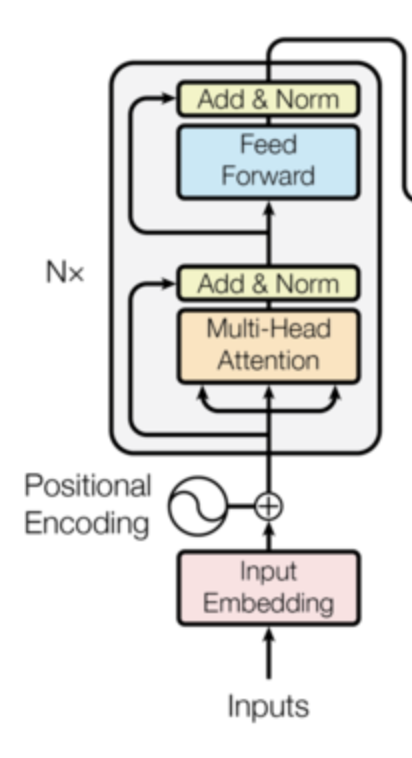

In [6]:
class Encoder(nn.Module):
    '''Single Encoder layer
    input : embedded src with positional encoding
    output : hidden representations z (applied multi-head attention, feed-forward)
    '''
    def __init__(self, layer, N):
        super().__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer)

In [7]:
class EncoderLayer(nn.Module):
    '''Core of encoder : self-attention -> feed forward'''
    def __init__(self, size, self_att, ff, dropout):
        super().__init__()
        self.self_att = self_att
        self.ff = ff
        self.sublayer = clones(ResConnection(size, dropout), 2) # self-attention, ff 둘 다 layernorm(residual connection) 적용하기 위함
        self.size = size
    
    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_att(x,x,x,mask)) # query, key, value
        return self.sublayer[1](x, self.ff)

## Decoder

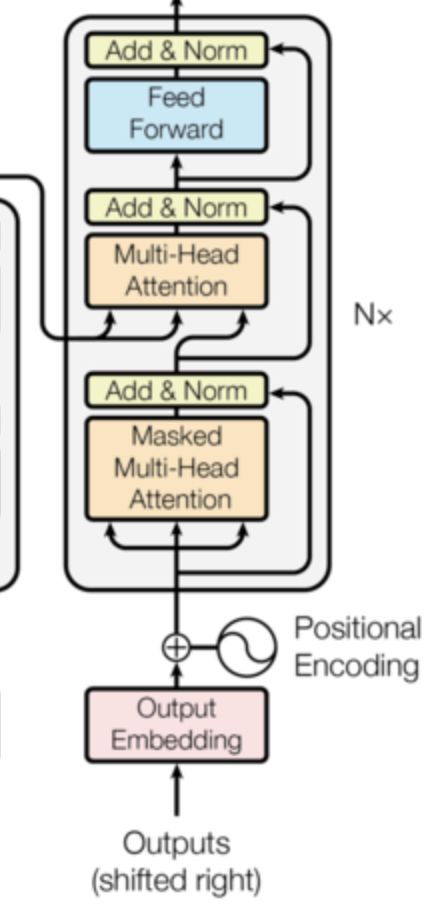

In [8]:
class Decoder(nn.Module):
    '''N-layer decoder with masked attention'''
    def __init__(self, layer, N):
        super().__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tar_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tar_mask)
        return self.norm(x)

In [9]:
class DecoderLayer(nn.Module):
    def __init__(self, size, self_att, src_att, ff, dropout):
        super().__init__()
        self.size = size
        self.self_att = self_att
        self.src_att = src_att
        self.ff = ff
        self.sublayer = clones(ResConnection(size, dropout), 3) # masked self-att, self-att, ff 모두 layernorm(residual connection) 적용
        
    def forward(self, x, memory, src_mask, tar_mask):
        x = self.sublayer[0](x, lambda x: self.self_att(x,x,x,tar_mask))
        x = self.sublayer[1](x, lambda x: self.src_att(x, memory, memory, src_mask))
        return self.sublayer[2](x, self.ff)